##                                                AIT590-002|Term Project
###                 2020 U.S. Presidential Election Sentimental Analysis: Trump Vs. Biden Tweets

Team9: Elham Jafarghomi, Saravana Vallaban, HaniehSadat Taghavi
    

In [1]:
#Import required packages and libraries
import string                                # import string library function  
import re
import nltk
#nltk.download("vader_lexicon")               #only one time to download
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split #importing train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB                     
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.naive_bayes import BernoulliNB              
from sklearn import linear_model as lm

#Setting the display to maximum
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Section 1| Train Dataset 

In [2]:
#read in the training dataset as dataframe using pandas library
traindf = pd.read_csv('C:/Users/ellie/OneDrive/Documents/GMU/AIT590-Natural Language Processing/Project/train.csv', encoding = "ISO-8859-1")

In [3]:
#Get the dimention of the dataset
traindf.shape

(99982, 3)

In [4]:
#check the number of duplicate rows
traindfrow = traindf[traindf.duplicated()]
print("Duplicate Rows:")
print(traindfrow)
# ==> There is no duplicate

Duplicate Rows:
Empty DataFrame
Columns: [ItemID, Sentiment, SentimentText]
Index: []


In [5]:
#check the number of missing values 
traindf.isnull().sum()
# ==> There is no missing values

ItemID           0
Sentiment        0
SentimentText    0
dtype: int64

In [6]:
#Display train dataset summary
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99982 entries, 0 to 99981
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ItemID         99982 non-null  int64 
 1   Sentiment      99982 non-null  int64 
 2   SentimentText  99982 non-null  object
dtypes: int64(2), object(1)
memory usage: 2.3+ MB


In [7]:
#Display the first 6 row of the train dataset
traindf.head(6)

ItemID  Sentiment  \
0       1          0   
1       2          0   
2       3          1   
3       4          0   
4       5          0   
5       6          0   

                                                                                                                          SentimentText  
0                                                                                              is so sad for my APL friend.............  
1                                                                                                      I missed the New Moon trailer...  
2                                                                                                               omg its already 7:30 :O  
3            .. Omgaga. Im sooo  im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...  
4                                                                                          i think mi bf is cheating on me!!!       T_T  
5                                                                                                     or i just worry too much?

In [8]:
#Drop the column that will not be used in this analysis; get the text and matching labels
traindf.drop(['ItemID'], inplace=True, axis=1)

In [9]:
#Decode the binary labels to Positive and Negative sentiment label for the visualization purpose 
decode_map = {0: "Negative", 1: "Positive"}
def sentiment_decode(label):
    return decode_map[int(label)]
traindf.Sentiment = traindf.Sentiment .apply(lambda x: sentiment_decode(x))
traindf.head(6)

Sentiment  \
0  Negative   
1  Negative   
2  Positive   
3  Negative   
4  Negative   
5  Negative   

                                                                                                                          SentimentText  
0                                                                                              is so sad for my APL friend.............  
1                                                                                                      I missed the New Moon trailer...  
2                                                                                                               omg its already 7:30 :O  
3            .. Omgaga. Im sooo  im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...  
4                                                                                          i think mi bf is cheating on me!!!       T_T  
5                                                                                                     or i just worry too much?

number of positve tagged sentimentText is:  56457
number of negative tagged sentimentText is: 43525
total number of rows are: 99982


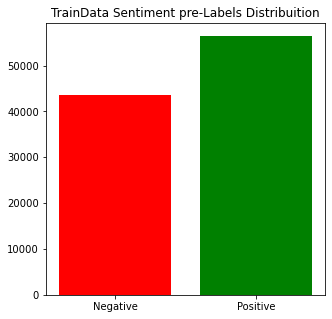

In [10]:
#Exploratory Analysis; plotting the Sentiment pre-labels distribution
Sentiment_count = Counter(traindf.Sentiment)

plt.figure(figsize=(5,5))
plt.bar(Sentiment_count.keys(), Sentiment_count.values(), color =['red', 'Green'])
plt.title("TrainData Sentiment pre-Labels Distribuition")

#Printing the number of positive and negative labels
print('number of positve tagged sentimentText is:  {}'.format(len(traindf['Sentiment'][traindf.Sentiment == 'Positive'])))
print('number of negative tagged sentimentText is: {}'.format(len(traindf['Sentiment'][traindf.Sentiment == 'Negative'])))
print('total number of rows are: {}'.format(traindf.shape[0]))

#Note ==> Positive and Negatives seem to be fairly distributed

## Data Preprocessing 
In our data cleaning process we found that it works much better to first tokenize the data before text cleaning in our case.

In [11]:
#Function to tokenize the text column
def tokenize_text(textdata):
    textdata= textdata.lower()
    textdata = word_tokenize(textdata)
    return textdata
traindf['tokens'] = traindf['SentimentText'].apply(lambda x: tokenize_text(x.lower()))
traindf.head()

Sentiment  \
0  Negative   
1  Negative   
2  Positive   
3  Negative   
4  Negative   

                                                                                                                          SentimentText  \
0                                                                                              is so sad for my APL friend.............   
1                                                                                                      I missed the New Moon trailer...   
2                                                                                                               omg its already 7:30 :O   
3            .. Omgaga. Im sooo  im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...   
4                                                                                          i think mi bf is cheating on me!!!       T_T   

                                                                                                                                                              tokens  
0                                                                                                                 [is, so, sad, for, my, apl, friend, .............]  
1                                                                                                                          [i, missed, the, new, moon, trailer, ...]  
2                                                                                                                                    [omg, its, already, 7:30, :, o]  
3  [.., omgaga, ., im, sooo, im, gunna, cry, ., i, 've, been, at, this, dentist, since, 11, .., i, was, suposed, 2, just, get, a, crown, put, on, (, 30mins, ), ...]  
4                                                                                                             [i, think, mi, bf, is, cheating, on, me, !, !, !, t_t]

In [12]:
#Function to lemmatize the words and get the root of words
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemma(textdata):
    textdata = [lemmatizer.lemmatize(token, pos="v") for token in textdata]
    return textdata

traindf['lemma_tokens'] = traindf['tokens'].apply(lambda x: lemma(x))
traindf.head(6)

Sentiment  \
0  Negative   
1  Negative   
2  Positive   
3  Negative   
4  Negative   
5  Negative   

                                                                                                                          SentimentText  \
0                                                                                              is so sad for my APL friend.............   
1                                                                                                      I missed the New Moon trailer...   
2                                                                                                               omg its already 7:30 :O   
3            .. Omgaga. Im sooo  im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...   
4                                                                                          i think mi bf is cheating on me!!!       T_T   
5                                                                                                     or i just worry too much?           

                                                                                                                                                              tokens  \
0                                                                                                                 [is, so, sad, for, my, apl, friend, .............]   
1                                                                                                                          [i, missed, the, new, moon, trailer, ...]   
2                                                                                                                                    [omg, its, already, 7:30, :, o]   
3  [.., omgaga, ., im, sooo, im, gunna, cry, ., i, 've, been, at, this, dentist, since, 11, .., i, was, suposed, 2, just, get, a, crown, put, on, (, 30mins, ), ...]   
4                                                                                                             [i, think, mi, bf, is, cheating, on, me, !, !, !, t_t]   
5                                                                                                                                 [or, i, just, worry, too, much, ?]   

                                                                                                                                                     lemma_tokens  
0                                                                                                              [be, so, sad, for, my, apl, friend, .............]  
1                                                                                                                         [i, miss, the, new, moon, trailer, ...]  
2                                                                                                                                 [omg, its, already, 7:30, :, o]  
3  [.., omgaga, ., im, sooo, im, gunna, cry, ., i, 've, be, at, this, dentist, since, 11, .., i, be, suposed, 2, just, get, a, crown, put, on, (, 30mins, ), ...]  
4                                                                                                             [i, think, mi, bf, be, cheat, on, me, !, !, !, t_t]  
5                                                                                                                              [or, i, just, worry, too, much, ?]

In [13]:
#Removing stopwords using spacy; stopwords are customized such that some words that are not written correctly such as mi instead 
#of my and etc, be added to stopwords for rwmoval and some words are excluded since the number of spacy stopwordfs are 
#double of the nltk

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
STOP_WORDS |= {"mi", "gon", "na", "cause", "atleast", "wiiit", "doin"}
STOP_WORDS -= {"less", "serious", "against", "enough", "never", "few", "more", "most", "mostly", "together", "very", 
              "many", "former", "say", "behind", "again", "beyond", "least"}
def remove_stopwords(textdata):
    textdata = [token for token in textdata if token not in STOP_WORDS]
    return textdata

traindf['nostop_tokens'] = traindf['lemma_tokens'].apply(lambda x: remove_stopwords(x))
traindf.head(6)

Sentiment  \
0  Negative   
1  Negative   
2  Positive   
3  Negative   
4  Negative   
5  Negative   

                                                                                                                          SentimentText  \
0                                                                                              is so sad for my APL friend.............   
1                                                                                                      I missed the New Moon trailer...   
2                                                                                                               omg its already 7:30 :O   
3            .. Omgaga. Im sooo  im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...   
4                                                                                          i think mi bf is cheating on me!!!       T_T   
5                                                                                                     or i just worry too much?           

                                                                                                                                                              tokens  \
0                                                                                                                 [is, so, sad, for, my, apl, friend, .............]   
1                                                                                                                          [i, missed, the, new, moon, trailer, ...]   
2                                                                                                                                    [omg, its, already, 7:30, :, o]   
3  [.., omgaga, ., im, sooo, im, gunna, cry, ., i, 've, been, at, this, dentist, since, 11, .., i, was, suposed, 2, just, get, a, crown, put, on, (, 30mins, ), ...]   
4                                                                                                             [i, think, mi, bf, is, cheating, on, me, !, !, !, t_t]   
5                                                                                                                                 [or, i, just, worry, too, much, ?]   

                                                                                                                                                     lemma_tokens  \
0                                                                                                              [be, so, sad, for, my, apl, friend, .............]   
1                                                                                                                         [i, miss, the, new, moon, trailer, ...]   
2                                                                                                                                 [omg, its, already, 7:30, :, o]   
3  [.., omgaga, ., im, sooo, im, gunna, cry, ., i, 've, be, at, this, dentist, since, 11, .., i, be, suposed, 2, just, get, a, crown, put, on, (, 30mins, ), ...]   
4                                                                                                             [i, think, mi, bf, be, cheat, on, me, !, !, !, t_t]   
5                                                                                                                              [or, i, just, worry, too, much, ?]   

                                                                                         nostop_tokens  
0                                                                    [sad, apl, friend, .............]  
1                                                                      [miss, new, moon, trailer, ...]  
2                                                                                    [omg, 7:30, :, o]  
3  [.., omgaga, ., im, sooo, im, gunna, cry, ., dentist, 11, .., suposed, 2, crown, (, 30mins, ), ...]  
4                                                               

In [14]:
#Create a new column to store text after stopwords removal and lemmatization
traindf['nostop_string'] = [' '.join(map(str, lists)) for lists in traindf['nostop_tokens']]
traindf.head()

Sentiment  \
0  Negative   
1  Negative   
2  Positive   
3  Negative   
4  Negative   

                                                                                                                          SentimentText  \
0                                                                                              is so sad for my APL friend.............   
1                                                                                                      I missed the New Moon trailer...   
2                                                                                                               omg its already 7:30 :O   
3            .. Omgaga. Im sooo  im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...   
4                                                                                          i think mi bf is cheating on me!!!       T_T   

                                                                                                                                                              tokens  \
0                                                                                                                 [is, so, sad, for, my, apl, friend, .............]   
1                                                                                                                          [i, missed, the, new, moon, trailer, ...]   
2                                                                                                                                    [omg, its, already, 7:30, :, o]   
3  [.., omgaga, ., im, sooo, im, gunna, cry, ., i, 've, been, at, this, dentist, since, 11, .., i, was, suposed, 2, just, get, a, crown, put, on, (, 30mins, ), ...]   
4                                                                                                             [i, think, mi, bf, is, cheating, on, me, !, !, !, t_t]   

                                                                                                                                                     lemma_tokens  \
0                                                                                                              [be, so, sad, for, my, apl, friend, .............]   
1                                                                                                                         [i, miss, the, new, moon, trailer, ...]   
2                                                                                                                                 [omg, its, already, 7:30, :, o]   
3  [.., omgaga, ., im, sooo, im, gunna, cry, ., i, 've, be, at, this, dentist, since, 11, .., i, be, suposed, 2, just, get, a, crown, put, on, (, 30mins, ), ...]   
4                                                                                                             [i, think, mi, bf, be, cheat, on, me, !, !, !, t_t]   

                                                                                         nostop_tokens  \
0                                                                    [sad, apl, friend, .............]   
1                                                                      [miss, new, moon, trailer, ...]   
2                                                                                    [omg, 7:30, :, o]   
3  [.., omgaga, ., im, sooo, im, gunna, cry, ., dentist, 11, .., suposed, 2, crown, (, 30mins, ), ...]   
4                                                                     [think, bf, cheat, !, !, !, t_t]   

                                                                     nostop_string  
0                                                     sad apl friend .............  
1                                                        miss new moon trailer ...  
2                                                                     omg 7:30 : o  
3  .. omgaga . im sooo im gunna cry . dentist 11 .. suposed 2 crown ( 30mins ) ...  
4             

## Punctuation Removal

In [15]:
#Storing the sets of punctuation in variable result  
punctuations = string.punctuation     
#Printing all punctuation 
print(punctuations)  

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [16]:
#Refrence https://www.kaggle.com/ragnisah/text-data-cleaning-tweets-analysis
#Function for removing punctuations, http, mentions and retweets is defined
def remove_punctuation(textdata):
   
    textdata = re.sub("(@[A-Za-z0-9]+)"," ", textdata)     #removing all user mentions 
    textdata = re.sub("([^0-9A-Za-z \t])"," ", textdata)
    textdata =re.sub(r'’https?:\/\/(www\.)?[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)', " ", textdata)
    textdata = re.sub('[0-9]+', '', textdata)     #removing all digits 
    textdata = re.sub(r'^rt[\s]+','', textdata)  # removes RT
    textdata = textdata.lower()
    textdata = "".join([char for char in textdata if char not in punctuations])

    return textdata
traindf['cleanedText'] = traindf['nostop_string'].apply(lambda x: remove_punctuation(x))
traindf.head(10)

Sentiment  \
0  Negative   
1  Negative   
2  Positive   
3  Negative   
4  Negative   
5  Negative   
6  Positive   
7  Negative   
8  Positive   
9  Positive   

                                                                                                                          SentimentText  \
0                                                                                              is so sad for my APL friend.............   
1                                                                                                      I missed the New Moon trailer...   
2                                                                                                               omg its already 7:30 :O   
3            .. Omgaga. Im sooo  im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...   
4                                                                                          i think mi bf is cheating on me!!!       T_T   
5                                                                                                     or i just worry too much?           
6                                                                                                    Juuuuuuuuuuuuuuuuussssst Chillin!!   
7                                                                                Sunny Again        Work Tomorrow  :-|       TV Tonight   
8                                                                                       handed in my uniform today . i miss you already   
9                                                                                              hmmmm.... i wonder how she my number @-)   

                                                                                                                                                              tokens  \
0                                                                                                                 [is, so, sad, for, my, apl, friend, .............]   
1                                                                                                                          [i, missed, the, new, moon, trailer, ...]   
2                                                                                                                                    [omg, its, already, 7:30, :, o]   
3  [.., omgaga, ., im, sooo, im, gunna, cry, ., i, 've, been, at, this, dentist, since, 11, .., i, was, suposed, 2, just, get, a, crown, put, on, (, 30mins, ), ...]   
4                                                                                                             [i, think, mi, bf, is, cheating, on, me, !, !, !, t_t]   
5                                                                                                                                 [or, i, just, worry, too, much, ?]   
6                                                                                                                          [juuuuuuuuuuuuuuuuussssst, chillin, !, !]   
7                                                                                                                 [sunny, again, work, tomorrow, :, -|, tv, tonight]   
8                                                                                                         [handed, in, my, uniform, today, ., i, miss, you, already]   
9                                                                                                            [hmmmm, ...., i, wonder, how, she, my, number, @, -, )]   

                                                                                                                                                     lemma_tokens  \
0                                                                                                              [be, so, sad, for, my, apl, friend, .............]   
1                                                                                                                         [i, m

In [17]:
#Short words such as tt, or and etc removal, since does not have any contribution  
traindf['cleanedText'] = traindf['cleanedText'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))
traindf.head(6)

Sentiment  \
0  Negative   
1  Negative   
2  Positive   
3  Negative   
4  Negative   
5  Negative   

                                                                                                                          SentimentText  \
0                                                                                              is so sad for my APL friend.............   
1                                                                                                      I missed the New Moon trailer...   
2                                                                                                               omg its already 7:30 :O   
3            .. Omgaga. Im sooo  im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...   
4                                                                                          i think mi bf is cheating on me!!!       T_T   
5                                                                                                     or i just worry too much?           

                                                                                                                                                              tokens  \
0                                                                                                                 [is, so, sad, for, my, apl, friend, .............]   
1                                                                                                                          [i, missed, the, new, moon, trailer, ...]   
2                                                                                                                                    [omg, its, already, 7:30, :, o]   
3  [.., omgaga, ., im, sooo, im, gunna, cry, ., i, 've, been, at, this, dentist, since, 11, .., i, was, suposed, 2, just, get, a, crown, put, on, (, 30mins, ), ...]   
4                                                                                                             [i, think, mi, bf, is, cheating, on, me, !, !, !, t_t]   
5                                                                                                                                 [or, i, just, worry, too, much, ?]   

                                                                                                                                                     lemma_tokens  \
0                                                                                                              [be, so, sad, for, my, apl, friend, .............]   
1                                                                                                                         [i, miss, the, new, moon, trailer, ...]   
2                                                                                                                                 [omg, its, already, 7:30, :, o]   
3  [.., omgaga, ., im, sooo, im, gunna, cry, ., i, 've, be, at, this, dentist, since, 11, .., i, be, suposed, 2, just, get, a, crown, put, on, (, 30mins, ), ...]   
4                                                                                                             [i, think, mi, bf, be, cheat, on, me, !, !, !, t_t]   
5                                                                                                                              [or, i, just, worry, too, much, ?]   

                                                                                         nostop_tokens  \
0                                                                    [sad, apl, friend, .............]   
1                                                                      [miss, new, moon, trailer, ...]   
2                                                                                    [omg, 7:30, :, o]   
3  [.., omgaga, ., im, sooo, im, gunna, cry, ., dentist, 11, .., suposed, 2, crown, (, 30mins, ), ...]   
4                                                          

In [18]:
#We use the tokenize function built earlier to tokenize clean text column after all data preprocessing and cleaning
traindf['cleanTweets'] = traindf['cleanedText'].apply(lambda x: tokenize_text(x.lower()))

In [19]:
#Dropping the extra columns created during data preprocessing and cleaning
columntodrop = ['SentimentText', 'tokens','lemma_tokens', 'nostop_tokens', 'nostop_string']
traindf.drop(columntodrop, inplace=True, axis=1)
traindf.head(6)

Sentiment                                       cleanedText  \
0  Negative                                    sad apl friend   
1  Negative                             miss new moon trailer   
2  Positive                                               omg   
3  Negative  omgaga sooo gunna cry dentist suposed crown mins   
4  Negative                                       think cheat   
5  Negative                                             worry   

                                                 cleanTweets  
0                                         [sad, apl, friend]  
1                                 [miss, new, moon, trailer]  
2                                                      [omg]  
3  [omgaga, sooo, gunna, cry, dentist, suposed, crown, mins]  
4                                             [think, cheat]  
5                                                    [worry]

In [20]:
#Getting the length of tokens in each tokenized tweet (after removing stopwords)
#convert column of lists to string
cleanTweets_len = []
for i in range(len(traindf['cleanTweets'])):
    cleanTweets_len.append(len(traindf['cleanTweets'][i]))

traindf['cleanTweets_count'] = cleanTweets_len
traindf.head(6)

Sentiment                                       cleanedText  \
0  Negative                                    sad apl friend   
1  Negative                             miss new moon trailer   
2  Positive                                               omg   
3  Negative  omgaga sooo gunna cry dentist suposed crown mins   
4  Negative                                       think cheat   
5  Negative                                             worry   

                                                 cleanTweets  \
0                                         [sad, apl, friend]   
1                                 [miss, new, moon, trailer]   
2                                                      [omg]   
3  [omgaga, sooo, gunna, cry, dentist, suposed, crown, mins]   
4                                             [think, cheat]   
5                                                    [worry]   

   cleanTweets_count  
0                  3  
1                  4  
2                  1  
3                  8  
4                  2  
5                  1

In [21]:
#Check to see if we have at least one token left after preprocessing and only keep those rows
traindf= traindf[traindf["cleanTweets_count"]>0]

In [22]:
#Resetting indexes after all cleaning
traindf.reset_index(inplace=True, drop=True)

In [23]:
#Get the dimention of the dataset;95 rows had no words remained after cleaning and they were only stopwords--not contributing
traindf.shape

(99887, 4)

## Word Cloud of positive and negative sentiments

In [24]:
#Creating dataframe for Positive and negative wordstems
Positive_sents= traindf[traindf['Sentiment']== "Positive"]
Negative_sents= traindf[traindf['Sentiment']== "Negative"]

In [25]:
#creating the list of positive and negative words for visualizations
positive_tokens = Positive_sents['cleanTweets'].tolist()
positive_tokens = [item for sublist in positive_tokens for item in sublist]

negative_tokens = Negative_sents['cleanTweets'].tolist()
negative_tokens = [item for sublist in negative_tokens for item in sublist]

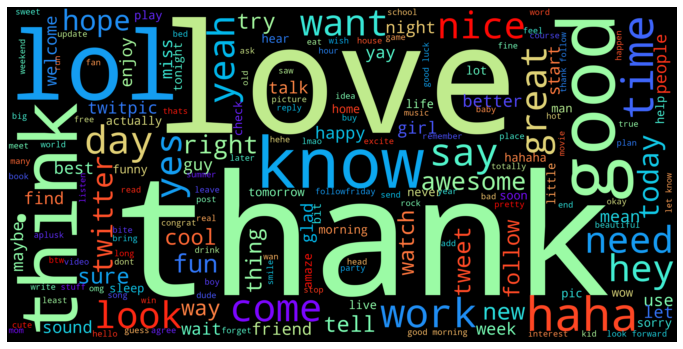

In [26]:
#creating wordcloud to visualize positive words in traindata
pos_wordcloud = WordCloud(max_font_size=100, max_words=400,scale=10,relative_scaling=.6,background_color="black", colormap = "rainbow").generate(', '.join(positive_tokens))

# Display the generated image:
plt.figure(figsize=(12,10))
plt.imshow(pos_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

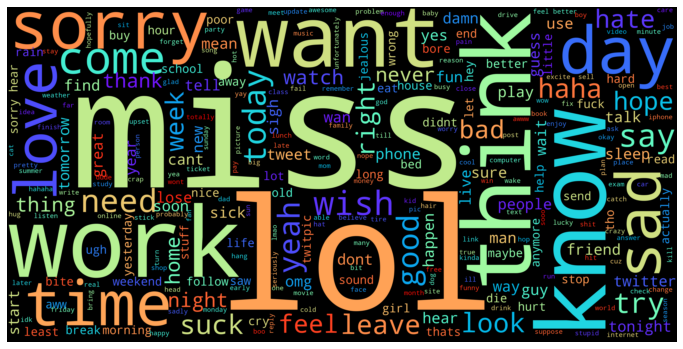

In [27]:
#creating wordcloud to visualize negative words in traindata
neg_wordcloud = WordCloud(max_font_size=100, max_words=400,scale=10,relative_scaling=.6,background_color="black", colormap = "rainbow").generate(', '.join(negative_tokens))

# Display the generated image:
plt.figure(figsize=(12,10))
plt.imshow(neg_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Sentiment Analysis Using Vader

In [28]:
#Renameing the SentimentIntensityAnalyzer to vader
vader = SentimentIntensityAnalyzer()

In [29]:
#Here we try a baseline solution accuray on the training dataset 
#A copy of the train data is created
traindf_baseline = traindf.copy(deep=True)

In [30]:
traindf_baseline['Sentiment scores'] = traindf_baseline['cleanedText'].apply(lambda cleanedText: vader.polarity_scores(cleanedText))
traindf_baseline.head(6)

Sentiment                                       cleanedText  \
0  Negative                                    sad apl friend   
1  Negative                             miss new moon trailer   
2  Positive                                               omg   
3  Negative  omgaga sooo gunna cry dentist suposed crown mins   
4  Negative                                       think cheat   
5  Negative                                             worry   

                                                 cleanTweets  \
0                                         [sad, apl, friend]   
1                                 [miss, new, moon, trailer]   
2                                                      [omg]   
3  [omgaga, sooo, gunna, cry, dentist, suposed, crown, mins]   
4                                             [think, cheat]   
5                                                    [worry]   

   cleanTweets_count  \
0                  3   
1                  4   
2                  1   
3                  8   
4                  2   
5                  1   

                                                 Sentiment scores  
0  {'neg': 0.425, 'neu': 0.137, 'pos': 0.438, 'compound': 0.0258}  
1   {'neg': 0.348, 'neu': 0.652, 'pos': 0.0, 'compound': -0.1531}  
2           {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}  
3   {'neg': 0.307, 'neu': 0.693, 'pos': 0.0, 'compound': -0.4767}  
4     {'neg': 0.75, 'neu': 0.25, 'pos': 0.0, 'compound': -0.4588}  
5       {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.4404}

In [31]:
#Create a column for the compound scores 
traindf_baseline['compound'] = traindf_baseline['Sentiment scores'].apply(lambda score_dict: score_dict['compound'])
traindf_baseline.head(2)

Sentiment            cleanedText                 cleanTweets  \
0  Negative         sad apl friend          [sad, apl, friend]   
1  Negative  miss new moon trailer  [miss, new, moon, trailer]   

   cleanTweets_count  \
0                  3   
1                  4   

                                                 Sentiment scores  compound  
0  {'neg': 0.425, 'neu': 0.137, 'pos': 0.438, 'compound': 0.0258}    0.0258  
1   {'neg': 0.348, 'neu': 0.652, 'pos': 0.0, 'compound': -0.1531}   -0.1531

In [32]:
#Decide sentiment as positive, negative and neutral
traindf_baseline['vaderSentiment'] = traindf_baseline['compound'].apply(lambda compound: 'Positive' if compound> 0 else ('Negative' if
                                                      compound<0 else 'Neutral'))
traindf_baseline.head(6)

Sentiment                                       cleanedText  \
0  Negative                                    sad apl friend   
1  Negative                             miss new moon trailer   
2  Positive                                               omg   
3  Negative  omgaga sooo gunna cry dentist suposed crown mins   
4  Negative                                       think cheat   
5  Negative                                             worry   

                                                 cleanTweets  \
0                                         [sad, apl, friend]   
1                                 [miss, new, moon, trailer]   
2                                                      [omg]   
3  [omgaga, sooo, gunna, cry, dentist, suposed, crown, mins]   
4                                             [think, cheat]   
5                                                    [worry]   

   cleanTweets_count  \
0                  3   
1                  4   
2                  1   
3                  8   
4                  2   
5                  1   

                                                 Sentiment scores  compound  \
0  {'neg': 0.425, 'neu': 0.137, 'pos': 0.438, 'compound': 0.0258}    0.0258   
1   {'neg': 0.348, 'neu': 0.652, 'pos': 0.0, 'compound': -0.1531}   -0.1531   
2           {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}    0.0000   
3   {'neg': 0.307, 'neu': 0.693, 'pos': 0.0, 'compound': -0.4767}   -0.4767   
4     {'neg': 0.75, 'neu': 0.25, 'pos': 0.0, 'compound': -0.4588}   -0.4588   
5       {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.4404}   -0.4404   

  vaderSentiment  
0       Positive  
1       Negative  
2        Neutral  
3       Negative  
4       Negative  
5       Negative

In [33]:
#Drop the neutral sentiments (compound scores of 0)
traindf_baseline= traindf_baseline[traindf_baseline.vaderSentiment!='Neutral']

In [34]:
from sklearn.metrics import accuracy_score
#Checking the vaderSentiment prediction with sentiment of the data (pre-labeled); the level of accuracy
print("Accuracy resulted from baseline solution is:")
round((accuracy_score(traindf_baseline['Sentiment'], traindf_baseline['vaderSentiment'])*100),2)

Accuracy resulted from baseline solution is:


69.7

## Model training Process

In [35]:
#Convert the cleanTweet tokens to clean text for being used in vectorization
traindf['cleanTweets'] = [','.join(map(str, lists)) for lists in traindf['cleanTweets']]

In [36]:
#Convert the sentiments to binary for using in model
traindf['Sentiment_binary'] = traindf['Sentiment'].map({'Positive':1, 'Negative':0})

In [37]:
#Drop the sentiment column with string positive and negrative names
traindf = traindf.drop("Sentiment", axis = 1)

In [38]:
#TF-IDF Vectorization
#Because our traindata and test data are two different datasets, and number of features are not the same, we use maximum 
#number of features that we can use in order to be able to run our model on our test datasets
tfidfvec = TfidfVectorizer(max_features = 2000, ngram_range=(1,2)).fit(traindf.cleanTweets)

# create matrix from the vectorizer
V = tfidfvec.transform(traindf.cleanTweets)

# create the transformed df
transformed_df = pd.DataFrame(V.toarray(), columns=tfidfvec.get_feature_names())
d = traindf.join(transformed_df)
d.head()

cleanedText  \
0                                    sad apl friend   
1                             miss new moon trailer   
2                                               omg   
3  omgaga sooo gunna cry dentist suposed crown mins   
4                                       think cheat   

                                        cleanTweets  cleanTweets_count  \
0                                    sad,apl,friend                  3   
1                             miss,new,moon,trailer                  4   
2                                               omg                  1   
3  omgaga,sooo,gunna,cry,dentist,suposed,crown,mins                  8   
4                                       think,cheat                  2   

   Sentiment_binary  aaron  able  absolutely  abt  accept  access  accident  \
0                 0    0.0   0.0         0.0  0.0     0.0     0.0       0.0   
1                 0    0.0   0.0         0.0  0.0     0.0     0.0       0.0   
2                 1    0.0   0.0         0.0  0.0     0.0     0.0       0.0   
3                 0    0.0   0.0         0.0  0.0     0.0     0.0       0.0   
4                 0    0.0   0.0         0.0  0.0     0.0     0.0       0.0   

   account  ace  ache  act  action  actual  actually  adam  add  add train  \
0      0.0  0.0   0.0  0.0     0.0     0.0       0.0   0.0  0.0        0.0   
1      0.0  0.0   0.0  0.0     0.0     0.0       0.0   0.0  0.0        0.0   
2      0.0  0.0   0.0  0.0     0.0     0.0       0.0   0.0  0.0        0.0   
3      0.0  0.0   0.0  0.0     0.0     0.0       0.0   0.0  0.0        0.0   
4      0.0  0.0   0.0  0.0     0.0     0.0       0.0   0.0  0.0        0.0   

   addict  address  admit  adorable  adrienne  advice  afford  afraid  \
0     0.0      0.0    0.0       0.0       0.0     0.0     0.0     0.0   
1     0.0      0.0    0.0       0.0       0.0     0.0     0.0     0.0   
2     0.0      0.0    0.0       0.0       0.0     0.0     0.0     0.0   
3     0.0      0.0    0.0       0.0       0.0     0.0     0.0     0.0   
4     0.0      0.0    0.0       0.0       0.0     0.0     0.0     0.0   

   afternoon  again  against  age  agent  ago  agree  aha  ahaha  ahead  ahh  \
0        0.0    0.0      0.0  0.0    0.0  0.0    0.0  0.0    0.0    0.0  0.0   
1        0.0    0.0      0.0  0.0    0.0  0.0    0.0  0.0    0.0    0.0  0.0   
2        0.0    0.0      0.0  0.0    0.0  0.0    0.0  0.0    0.0    0.0  0.0   
3        0.0    0.0      0.0  0.0    0.0  0.0    0.0  0.0    0.0    0.0  0.0   
4        0.0    0.0      0.0  0.0    0.0  0.0    0.0  0.0    0.0    0.0  0.0   

   ahhh  aim  aint  air  airport  aka  alan  alancarr  album  alex  \
0   0.0  0.0   0.0  0.0      0.0  0.0   0.0       0.0    0.0   0.0   
1   0.0  0.0   0.0  0.0      0.0  0.0   0.0       0.0    0.0   0.0   
2   0.0  0.0   0.0  0.0      0.0  0.0   0.0       0.0    0.0   0.0   
3   0.0  0.0   0.0  0.0      0.0  0.0   0.0       0.0    0.0   0.0   
4   0.0  0.0   0.0  0.0      0.0  0.0   0.0       0.0    0.0   0.0   

   alexalltimelow  alexandramusic  ali  alice  alive  all  allow  ally  alot  \
0             0.0             0.0  0.0    0.0    0.0  0.0    0.0   0.0   0.0   
1             0.0             0.0  0.0    0.0    0.0  0.0    0.0   0.0   0.0   
2             0.0             0.0  0.0    0.0    0.0  0.0    0.0   0.0   0.0   
3             0.0             0.0  0.0    0.0    0.0  0.0    0.0   0.0   0.0   
4             0.0             0.0  0.0    0.0    0.0  0.0    0.0   0.0   0.0   

   alright  alyankovic  alyssa  alyssa milano  amanda  amanda holden  \
0      0.0         0.0     0.0            0.0     0.0            0.0   
1      0.0         0.0     0.0            0.0     0.0            0.0   
2      0.0         0.0     0.0            0.0     0.0            0.0   
3      0.0         0.0     0.0            0.0     0.0            0.0   
4      0.0         0.0     0.0            0.0     0.0            0.0   

   amandabynes  amandapalmer  amaze  amber  amber benson  america

In [39]:
#Drop the columns that are not useful for the model
d = d.drop(["cleanedText","cleanTweets","cleanTweets_count"], axis = 1)
d.head(4)

Sentiment_binary  aaron  able  absolutely  abt  accept  access  accident  \
0                 0    0.0   0.0         0.0  0.0     0.0     0.0       0.0   
1                 0    0.0   0.0         0.0  0.0     0.0     0.0       0.0   
2                 1    0.0   0.0         0.0  0.0     0.0     0.0       0.0   
3                 0    0.0   0.0         0.0  0.0     0.0     0.0       0.0   

   account  ace  ache  act  action  actual  actually  adam  add  add train  \
0      0.0  0.0   0.0  0.0     0.0     0.0       0.0   0.0  0.0        0.0   
1      0.0  0.0   0.0  0.0     0.0     0.0       0.0   0.0  0.0        0.0   
2      0.0  0.0   0.0  0.0     0.0     0.0       0.0   0.0  0.0        0.0   
3      0.0  0.0   0.0  0.0     0.0     0.0       0.0   0.0  0.0        0.0   

   addict  address  admit  adorable  adrienne  advice  afford  afraid  \
0     0.0      0.0    0.0       0.0       0.0     0.0     0.0     0.0   
1     0.0      0.0    0.0       0.0       0.0     0.0     0.0     0.0   
2     0.0      0.0    0.0       0.0       0.0     0.0     0.0     0.0   
3     0.0      0.0    0.0       0.0       0.0     0.0     0.0     0.0   

   afternoon  again  against  age  agent  ago  agree  aha  ahaha  ahead  ahh  \
0        0.0    0.0      0.0  0.0    0.0  0.0    0.0  0.0    0.0    0.0  0.0   
1        0.0    0.0      0.0  0.0    0.0  0.0    0.0  0.0    0.0    0.0  0.0   
2        0.0    0.0      0.0  0.0    0.0  0.0    0.0  0.0    0.0    0.0  0.0   
3        0.0    0.0      0.0  0.0    0.0  0.0    0.0  0.0    0.0    0.0  0.0   

   ahhh  aim  aint  air  airport  aka  alan  alancarr  album  alex  \
0   0.0  0.0   0.0  0.0      0.0  0.0   0.0       0.0    0.0   0.0   
1   0.0  0.0   0.0  0.0      0.0  0.0   0.0       0.0    0.0   0.0   
2   0.0  0.0   0.0  0.0      0.0  0.0   0.0       0.0    0.0   0.0   
3   0.0  0.0   0.0  0.0      0.0  0.0   0.0       0.0    0.0   0.0   

   alexalltimelow  alexandramusic  ali  alice  alive  all  allow  ally  alot  \
0             0.0             0.0  0.0    0.0    0.0  0.0    0.0   0.0   0.0   
1             0.0             0.0  0.0    0.0    0.0  0.0    0.0   0.0   0.0   
2             0.0             0.0  0.0    0.0    0.0  0.0    0.0   0.0   0.0   
3             0.0             0.0  0.0    0.0    0.0  0.0    0.0   0.0   0.0   

   alright  alyankovic  alyssa  alyssa milano  amanda  amanda holden  \
0      0.0         0.0     0.0            0.0     0.0            0.0   
1      0.0         0.0     0.0            0.0     0.0            0.0   
2      0.0         0.0     0.0            0.0     0.0            0.0   
3      0.0         0.0     0.0            0.0     0.0            0.0   

   amandabynes  amandapalmer  amaze  amber  amber benson  america  american  \
0          0.0           0.0    0.0    0.0           0.0      0.0       0.0   
1          0.0           0.0    0.0    0.0           0.0      0.0       0.0   
2          0.0           0.0    0.0    0.0           0.0      0.0       0.0   
3          0.0           0.0    0.0    0.0           0.0      0.0       0.0   

   amy  ana  and  andrea  andrew  andy  andyclemmensen  ang  angel  angela  \
0  0.0  0.0  0.0     0.0     0.0   0.0             0.0  0.0    0.0     0.0   
1  0.0  0.0  0.0     0.0     0.0   0.0             0.0  0.0    0.0     0.0   
2  0.0  0.0  0.0     0.0     0.0   0.0             0.0  0.0    0.0     0.0   
3  0.0  0.0  0.0     0.0     0.0   0.0             0.0  0.0    0.0     0.0   

   angry  animals  anime  ann  anna  anne  annoy  anoopdoggdesai  answer  \
0    0.0      0.0    0.0  0.0   0.0   0.0    0.0             0.0     0.0   
1    0.0      0.0    0.0  0.0   0.0   0.0    0.0             0.0     0.0   
2    0.0      0.0    0.0  0.0   0.0   0.0    0.0             0.0     0.0   
3    0.0      0.0    0.0  0.0   0.0   0.0    0.0             0.0     0.0   

   anthony  anymore  anytime  anyways  anz  anz rocks  apart  aplusk  app  \
0      0.0      0.0      0.0      0.0  0.0        0.0    0.0     0.0  0.0   
1      0.0    

# Train the Logistic Regression Model

In [40]:
#logistic regression classifier
y = d.Sentiment_binary
X = d.drop('Sentiment_binary', axis=1)

#split the data to train and test for predicting sentiment of text
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=123)

#Call the logistic regression model for training 
log_reg = LogisticRegression(max_iter=4000).fit(X_train, y_train)

#predict the sentiment on the text data
y_pred = log_reg.predict(X_test)

#Print the accuracy resulted from logistic regression model
accuracy_score_lr = metrics.accuracy_score(y_pred,y_test)
print("Accuracy resulted from Logistic Regression model is:")
print(str('{:04.2f}'.format(accuracy_score_lr*100))+ '%')


#Print the confusion Matrix for the model
cfmatrix_lr = confusion_matrix(y_test, y_pred)
print('Confusion Matrix for the Logistic Regression model\n')
print(cfmatrix_lr)

#Print the classification report including the Precision, Recall and F1 Score 
print(classification_report(y_test, y_pred))


Accuracy resulted from Logistic Regression model is:
73.39%
Confusion Matrix for the Logistic Regression model

[[5292 3364]
 [1953 9369]]
              precision    recall  f1-score   support

           0       0.73      0.61      0.67      8656
           1       0.74      0.83      0.78     11322

    accuracy                           0.73     19978
   macro avg       0.73      0.72      0.72     19978
weighted avg       0.73      0.73      0.73     19978



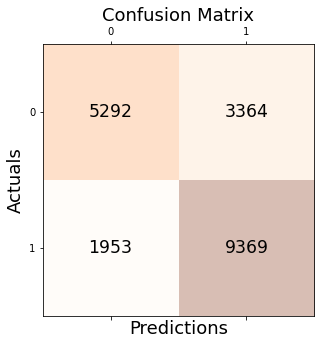

In [41]:
#Plot the confusion matrix
cfmatrix_lr = confusion_matrix(y_true=y_test, y_pred=y_pred)

# Print the confusion matrix using Matplotlib

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cfmatrix_lr, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(cfmatrix_lr.shape[0]):
    for j in range(cfmatrix_lr.shape[1]):
        ax.text(x=j, y=i,s=cfmatrix_lr[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

## Train the Multinomial Naive Bayes Model

In [42]:
#split the data to train and test for predicting sentiment of text
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.20, random_state =123)

#Defining the model; will filt Multinominal NB model
model = MultinomialNB()
model.fit(X_train, y_train)

model.score(X_test, y_test)
#predict on test data
y_predict = model.predict(X_test)

##Print the accuracy resulted from Multinomial NB model
accuracy_score = metrics.accuracy_score(y_predict,y_test)
print("Accuracy resulted from Naive Bayes classifier is:")
print(str('{:04.2f}'.format(accuracy_score*100))+ '%')

#Print the classification report including the Precision, Recall and F1 Score 
print(classification_report(y_test, y_predict))

Accuracy resulted from Naive Bayes classifier is:
72.89%
              precision    recall  f1-score   support

           0       0.73      0.59      0.66      8656
           1       0.73      0.83      0.78     11322

    accuracy                           0.73     19978
   macro avg       0.73      0.71      0.72     19978
weighted avg       0.73      0.73      0.72     19978



# Train the Bernoulli Naive Bayes Model

In [43]:
#split the data to train and test for predicting sentiment of text
X_trainb, X_testb, y_trainb, y_testb = train_test_split(X, y, test_size =0.20, random_state =123)

#Calling the bernoulli model 
Bmodel = BernoulliNB().fit(X_trainb,y_trainb)

#Predict on test data
yb_predict = Bmodel.predict(X_testb)

#Print the accuracy resulted from Bernoulli NB model
accuracy_score_b = metrics.accuracy_score(yb_predict,y_testb)
print("Accuracy resulted from  Bernoulli Naive Bayes classifier is:")
print(str('{:04.2f}'.format(accuracy_score_b*100))+ '%')

#Print the classification report including the Precision, Recall and F1 Score 
print(classification_report(y_testb, yb_predict))

Accuracy resulted from  Bernoulli Naive Bayes classifier is:
72.70%
              precision    recall  f1-score   support

           0       0.70      0.65      0.67      8656
           1       0.75      0.78      0.77     11322

    accuracy                           0.73     19978
   macro avg       0.72      0.72      0.72     19978
weighted avg       0.73      0.73      0.73     19978



## 

## Section 2| Test Datasets 
In this section, we will read Donald Trump and Joe Biden tweets dataset that were scrapped from their twitter accounts, and will do all cleaning steps that we did for the general train data above. We then the sentiment analysis using our best performing model that we trained on a general pre-labeled tweet dataset.

## Donald Trump Tweets data

In [44]:
#Read in the trump dataset as dataframe 
trumpdf = pd.read_csv('C:/Users/ellie/OneDrive/Documents/GMU/AIT590-Natural Language Processing/Project/Trump.csv', encoding = "ISO-8859-1")
trumpdf.head(6)

Date  \
0  11/2/2020   
1  11/2/2020   
2  11/2/2020   
3  11/2/2020   
4  11/2/2020   
5  11/2/2020   

                                                                                                                                                                                                                                                                                      Tweet  
0                                                                                                                                                                                                                                        Just landed in Traverse City, Michigan. Big crowd!  
1                                                   As Christians throughout this great Country celebrate All Souls Day, let's remember those who went before us and built this great nation. May their legacy inspire us as we keep our nation what it has always been: blessed and great!  
2         Joe Biden is promising to delay the vaccine and turn America into a prison state-locking you in your home while letting far-left rioters roam free. The Biden Lockdown will mean no school, no graduations, no weddings, no Thanksgiving, no Christmas, no Fourth of July, and...  
3  Joe Biden is a globalist who spent 47 years outsourcing your jobs, opening your borders, and sacrificing American blood and treasure in endless foreign wars. He shuttered your steel mills, annihilated your coal jobs, and supported every disastrous trade deal for half a century...  
4                                                                                                                       I gave Maine everything that Obama/Biden took away from it. 5000 square miles, Lobster, Fishing, ended tariffs from China and E.U. and much more. Vote Trump Maine!  
5                                                                                                                                                                                                                                                        Landing in Scranton, Pennsylvania!

In [45]:
##Get the dimention of trump tweets dataset
trumpdf.shape

(2570, 2)

In [46]:
#Drop the dupicates 
trumpdf=trumpdf.drop_duplicates()

In [47]:
#Reset indexes after dropping duplicates
trumpdf.reset_index(inplace=True, drop=True)

In [48]:
#Check the dimention after dropping duplicates
trumpdf.shape

(1411, 2)

In [49]:
#check the number of missing values 
trumpdf.isnull().sum()
# ==> There is no missing values

Date     0
Tweet    0
dtype: int64

In [50]:
#Tokenize the tweets using the tokenize function defined earlier in the code in section 1
trumpdf['tokens'] = trumpdf['Tweet'].apply(lambda x: tokenize_text(x.lower()))

In [51]:
#Lemmatize tweets ussing the pre-defined function for lemmatizing the tokens in section 1
trumpdf['lemma_tokens'] =trumpdf['tokens'].apply(lambda x: lemma(x))

In [52]:
#Remove stopwords using the pre-defined function for removing stopwords in section 1
trumpdf['nostop_tokens'] = trumpdf['lemma_tokens'].apply(lambda x: remove_stopwords(x))

In [53]:
#Put back the nostop_tokens to sentence format for enabling to use punctuation removal later
trumpdf['nostop_string'] = [' '.join(map(str, lists)) for lists in trumpdf['nostop_tokens']]

In [54]:
#Remove all punctuations, mentions, url links and hashtags using the function defined earlier in section 1
trumpdf['cleanedText'] = trumpdf['nostop_string'].apply(lambda x: remove_punctuation(x))

In [55]:
#Remove all short words that has no meaning and does contribute  
trumpdf['cleanedText'] = trumpdf['cleanedText'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

In [56]:
#Tokenize the tweets after all above cleaning process 
trumpdf['cleanTweets'] = trumpdf['cleanedText'].apply(lambda x: tokenize_text(x.lower()))
trumpdf.head(6)

Date  \
0  11/2/2020   
1  11/2/2020   
2  11/2/2020   
3  11/2/2020   
4  11/2/2020   
5  11/2/2020   

                                                                                                                                                                                                                                                                                      Tweet  \
0                                                                                                                                                                                                                                        Just landed in Traverse City, Michigan. Big crowd!   
1                                                   As Christians throughout this great Country celebrate All Souls Day, let's remember those who went before us and built this great nation. May their legacy inspire us as we keep our nation what it has always been: blessed and great!   
2         Joe Biden is promising to delay the vaccine and turn America into a prison state-locking you in your home while letting far-left rioters roam free. The Biden Lockdown will mean no school, no graduations, no weddings, no Thanksgiving, no Christmas, no Fourth of July, and...   
3  Joe Biden is a globalist who spent 47 years outsourcing your jobs, opening your borders, and sacrificing American blood and treasure in endless foreign wars. He shuttered your steel mills, annihilated your coal jobs, and supported every disastrous trade deal for half a century...   
4                                                                                                                       I gave Maine everything that Obama/Biden took away from it. 5000 square miles, Lobster, Fishing, ended tariffs from China and E.U. and much more. Vote Trump Maine!   
5                                                                                                                                                                                                                                                        Landing in Scranton, Pennsylvania!   

                                                                                                                                                                                                                                                                                                                                              tokens  \
0                                                                                                                                                                                                                                                                                  [just, landed, in, traverse, city, ,, michigan, ., big, crowd, !]   
1                                                         [as, christians, throughout, this, great, country, celebrate, all, souls, day, ,, let, 's, remember, those, who, went, before, us, and, built, this, great, nation, ., may, their, legacy, inspire, us, as, we, keep, our, nation, what, it, has, always, been, :, blessed, and, great, !]   
2    [joe, biden, is, promising, to, delay, the, vaccine, and, turn, america, into, a, prison, state-locking, you, in, your, home, while, letting, far-left, rioters, roam, free, ., the, biden, lockdown, will, mean, no, school, ,, no, graduations, ,, no, weddings, ,, no, thanksgiving, ,, no, christmas, ,, no, fourth, of, july, ,, and, ...]   
3  [joe, biden, is, a, globalist, who, spent, 47, years, outsourcing, your, jobs, ,, opening, your, borders, ,, and, sacrificing, american, blood, and, treasure, in, endless, foreign, wars, ., he, shuttered, your, steel, mills, ,, annihilated, your, coal, jobs, ,, and, supported, every, disastrous, trade, deal, for, half, a, century, ...]   
4                                                                                                                                      [i, gave, maine, everything, t

In [57]:
#Drop all the extra columns created during the data preprocess and cleaning
trumpdfDrop = ['Tweet','tokens','lemma_tokens', 'nostop_tokens', 'nostop_string','cleanedText']
trumpdf.drop(trumpdfDrop, inplace=True, axis=1)
trumpdf.head(3)

Date  \
0  11/2/2020   
1  11/2/2020   
2  11/2/2020   

                                                                                                                                                                                                            cleanTweets  
0                                                                                                                                                                          [land, traverse, city, michigan, big, crowd]  
1                                                                                       [christians, great, country, celebrate, souls, day, let, remember, build, great, nation, legacy, inspire, nation, bless, great]  
2  [joe, biden, promise, delay, vaccine, turn, america, prison, state, locking, home, let, far, left, rioters, roam, free, biden, lockdown, mean, school, graduations, weddings, thanksgiving, christmas, fourth, july]

In [58]:
# Getting the length of tokens in each tokenized tweet 
# convert column of lists to string
cleanTweets_len = []
for i in range(len(trumpdf['cleanTweets'])):
    cleanTweets_len.append(len(trumpdf['cleanTweets'][i]))

trumpdf['cleanTweets_count'] = cleanTweets_len
trumpdf.head(3)

Date  \
0  11/2/2020   
1  11/2/2020   
2  11/2/2020   

                                                                                                                                                                                                            cleanTweets  \
0                                                                                                                                                                          [land, traverse, city, michigan, big, crowd]   
1                                                                                       [christians, great, country, celebrate, souls, day, let, remember, build, great, nation, legacy, inspire, nation, bless, great]   
2  [joe, biden, promise, delay, vaccine, turn, america, prison, state, locking, home, let, far, left, rioters, roam, free, biden, lockdown, mean, school, graduations, weddings, thanksgiving, christmas, fourth, july]   

   cleanTweets_count  
0                  6  
1                 16  
2                 27

In [59]:
#Check to see if we have at least one token left after preprocessing and only keep those rows
trumpdf= trumpdf[trumpdf["cleanTweets_count"]>0]

#Get the data dimention
trumpdf.shape

(1411, 3)

In [60]:
#creating the list for tokens in Trump's tweets for using in wordcloud visualization
trump_tokens = trumpdf['cleanTweets'].tolist()
trump_tokens = [item for sublist in trump_tokens for item in sublist]

In [61]:
#Create picture for trump wordcloud
#Here we use donald trump picture as a mask for wordcloud of hos most frequent words
from PIL import Image
trump_image= np.array(Image.open("trump wordcloud.png"))

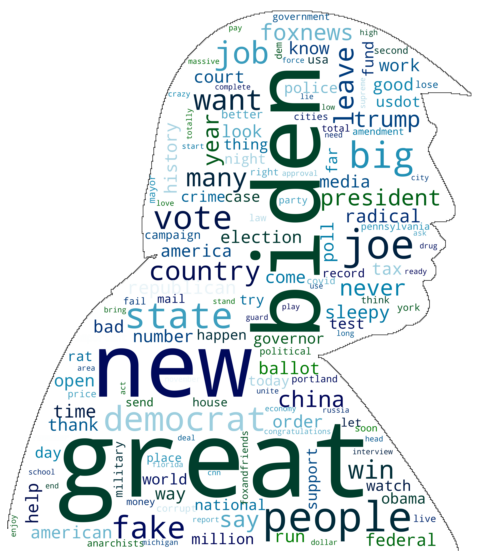

In [62]:
#Call the wordcloud function on trump tokens
wordcloud_trump = WordCloud(max_font_size=100, max_words=150,scale=10,relative_scaling=.6, background_color="white", contour_color="black",
                            contour_width= 3, mask= trump_image,colormap ="ocean", collocations=False).generate(', '.join(trump_tokens))

# Display the generated image:
plt.figure(figsize=(12,10))
plt.imshow(wordcloud_trump, interpolation='bilinear')
plt.axis("off")
plt.show()

# predicting Trump tweet's polarity using the Logistic regression model

In [63]:
#Convert the cleanTweet tokens to clean text for being used in vectorization
trumpdf['cleanTweets'] = [','.join(map(str, lists)) for lists in trumpdf['cleanTweets']]

In [64]:
##TF-IDF Vectorization on trump dataset
tfidfvec1 = TfidfVectorizer(max_features = 2000, ngram_range=(1,2)).fit(trumpdf.cleanTweets)

# create matrix from the vectorizer
V1 = tfidfvec1.transform(trumpdf.cleanTweets)

# create the transformed df
transformed_df1 = pd.DataFrame(V1.toarray(), columns=tfidfvec1.get_feature_names())
d1 = trumpdf.join(transformed_df1)

#Drop the columns that are not used in the model
d1 = d1.drop(["Date","cleanTweets", "cleanTweets_count" ],axis = 1)
d1.head()

abc  able  abolish  abolish police  absentee  absentee ballot  \
0  0.0   0.0      0.0             0.0       0.0              0.0   
1  0.0   0.0      0.0             0.0       0.0              0.0   
2  0.0   0.0      0.0             0.0       0.0              0.0   
3  0.0   0.0      0.0             0.0       0.0              0.0   
4  0.0   0.0      0.0             0.0       0.0              0.0   

   absentee vote  absolute  absolutely  abuse  accept  accord  accurate  act  \
0            0.0       0.0         0.0    0.0     0.0     0.0       0.0  0.0   
1            0.0       0.0         0.0    0.0     0.0     0.0       0.0  0.0   
2            0.0       0.0         0.0    0.0     0.0     0.0       0.0  0.0   
3            0.0       0.0         0.0    0.0     0.0     0.0       0.0  0.0   
4            0.0       0.0         0.0    0.0     0.0     0.0       0.0  0.0   

   act fund  action  actually  add  addition  additional  address  \
0       0.0     0.0       0.0  0.0       0.0         0.0      0.0   
1       0.0     0.0       0.0  0.0       0.0         0.0      0.0   
2       0.0     0.0       0.0  0.0       0.0         0.0      0.0   
3       0.0     0.0       0.0  0.0       0.0         0.0      0.0   
4       0.0     0.0       0.0  0.0       0.0         0.0      0.0   

   administration  admit  admit right  ads  advance  advertise  afghanistan  \
0             0.0    0.0          0.0  0.0      0.0        0.0          0.0   
1             0.0    0.0          0.0  0.0      0.0        0.0          0.0   
2             0.0    0.0          0.0  0.0      0.0        0.0          0.0   
3             0.0    0.0          0.0  0.0      0.0        0.0          0.0   
4             0.0    0.0          0.0  0.0      0.0        0.0          0.0   

   african  african american  again  against  against fracking  agenda  \
0      0.0               0.0    0.0      0.0               0.0     0.0   
1      0.0               0.0    0.0      0.0               0.0     0.0   
2      0.0               0.0    0.0      0.0               0.0     0.0   
3      0.0               0.0    0.0      0.0               0.0     0.0   
4      0.0               0.0    0.0      0.0               0.0     0.0   

   agitators  agitators anarchists  agitators looters  ago  agree  ahead  \
0        0.0                   0.0                0.0  0.0    0.0    0.0   
1        0.0                   0.0                0.0  0.0    0.0    0.0   
2        0.0                   0.0                0.0  0.0    0.0    0.0   
3        0.0                   0.0                0.0  0.0    0.0    0.0   
4        0.0                   0.0                0.0  0.0    0.0    0.0   

   ahead schedule  aid  air  air force  airport  airport grant  airports  \
0             0.0  0.0  0.0        0.0      0.0            0.0       0.0   
1             0.0  0.0  0.0        0.0      0.0            0.0       0.0   
2             0.0  0.0  0.0        0.0      0.0            0.0       0.0   
3             0.0  0.0  0.0        0.0      0.0            0.0       0.0   
4             0.0  0.0  0.0        0.0      0.0            0.0       0.0   

   airtime  alabama  alaska  all  all time  allegiance  allow  ally  amaze  \
0      0.0      0.0     0.0  0.0       0.0         0.0    0.0   0.0    0.0   
1      0.0      0.0     0.0  0.0       0.0         0.0    0.0   0.0    0.0   
2      0.0      0.0     0.0  0.0       0.0         0.0    0.0   0.0    0.0   
3      0.0      0.0     0.0  0.0       0.0         0.0    0.0   0.0    0.0   
4      0.0      0.0     0.0  0.0       0.0         0.0    0.0   0.0    0.0   

   amazon  amendment  amendment vote   america  america great  american  \
0     0.0        0.0             0.0  0.000000            0.0   0.00000   
1     0.0        0.0             0.0  0.000000            0.0   0.00000   
2     0.0        0.0             0.0  0.173567            0.0   0.00000   
3     0.0        0.0             0.0  0.000000            0.0   0.15562   
4     0.0        0.0

In [65]:
#Call the logistic regression model on trump data to predict the sentimnets of his tweets and store them on the predicted
#sentiment column
trumpdf['predicted_sentiment'] = log_reg.predict(d1)
#Display the first 6 rows
trumpdf.head(6)

Date  \
0  11/2/2020   
1  11/2/2020   
2  11/2/2020   
3  11/2/2020   
4  11/2/2020   
5  11/2/2020   

                                                                                                                                                                                         cleanTweets  \
0                                                                                                                                                              land,traverse,city,michigan,big,crowd   
1                                                                                     christians,great,country,celebrate,souls,day,let,remember,build,great,nation,legacy,inspire,nation,bless,great   
2           joe,biden,promise,delay,vaccine,turn,america,prison,state,locking,home,let,far,left,rioters,roam,free,biden,lockdown,mean,school,graduations,weddings,thanksgiving,christmas,fourth,july   
3  joe,biden,globalist,spend,years,outsource,job,open,border,sacrifice,american,blood,treasure,endless,foreign,war,shutter,steel,mill,annihilate,coal,job,support,disastrous,trade,deal,half,century   
4                                                                                                            maine,obama,biden,away,square,miles,lobster,fish,end,tariff,china,more,vote,trump,maine   
5                                                                                                                                                                         land,scranton,pennsylvania   

   cleanTweets_count  predicted_sentiment  
0                  6                    0  
1                 16                    0  
2                 27                    1  
3                 28                    1  
4                 15                    1  
5                  3                    1

In [66]:
#Decoding the binary labels to Positive and Negative sentiment label for the visualization purpose 
decode_map = {0: "Negative", 1: "Positive"}
def sentiment_decode(label):
    return decode_map[int(label)]
trumpdf.predicted_sentiment = trumpdf.predicted_sentiment .apply(lambda x: sentiment_decode(x))
trumpdf.head(3)

Date  \
0  11/2/2020   
1  11/2/2020   
2  11/2/2020   

                                                                                                                                                                                cleanTweets  \
0                                                                                                                                                     land,traverse,city,michigan,big,crowd   
1                                                                            christians,great,country,celebrate,souls,day,let,remember,build,great,nation,legacy,inspire,nation,bless,great   
2  joe,biden,promise,delay,vaccine,turn,america,prison,state,locking,home,let,far,left,rioters,roam,free,biden,lockdown,mean,school,graduations,weddings,thanksgiving,christmas,fourth,july   

   cleanTweets_count predicted_sentiment  
0                  6            Negative  
1                 16            Negative  
2                 27            Positive

In [67]:
#Print the percentage of positive and negative tweets of Donald Trump
tPositive_sents= round(len(trumpdf[trumpdf['predicted_sentiment']== "Positive"])*100/len(trumpdf['predicted_sentiment']), 2)
tNegative_sents=100-tPositive_sents

print("Trump Positive Sentiment percentage is:")
print(tPositive_sents , "%")    
print("Trump Negative Sentiment percentage is:")
print(tNegative_sents , "%")

Trump Positive Sentiment percentage is:
53.37 %
Trump Negative Sentiment percentage is:
46.63 %


# Joe Biden Tweets Data

In [68]:
#Read the Biden dataset as dataframe 
bidendf = pd.read_csv('C:/Users/ellie/OneDrive/Documents/GMU/AIT590-Natural Language Processing/Project/Biden.csv', encoding = "ISO-8859-1")
bidendf.head(6)

Date  \
0  11/2/2020   
1  11/2/2020   
2  11/2/2020   
3  11/2/2020   
4  11/2/2020   
5  11/2/2020   

                                                                                                                                                                                                                                                                                     Tweet  
0                                                      Donald Trump is the most corrupt president in modern history.  Donald Trump is the most racist president in modern history.  Donald Trump is the worst jobs president in modern history.  Why would we give him another four years?  
1                                                                                                                          Here's the truth: Donald Trump inherited a growing economy from President Obama and me. And just like everything else he's inherited in life, he squandered it.  
2                                                                                                          When America votes, America will be heard. And when America is heard, I believe the message is going to be loud and clear: It's time for Donald Trump to leave the White House.  
3  A Biden-Harris administration will:  - Implement nationwide mask mandates - Ensure access to regular, reliable, and free testing - Accelerate the development and distribution of safe and effective treatments and vaccines  We won't waste any time getting this virus under control.  
4                                                                                                                                                                 Together, we're going to rebuild our economy. And when we do, we'll not only build it back - we'll build it back better.  
5                                                             In public, President Trump compared COVID-19 to the flu and suggested people inject bleach to treat it.  In private, he told Bob Woodward it was deadlier than the flu and that he wanted to downplay it.  It's unthinkable.

In [69]:
#Get the dimention of biden tweets dataset
bidendf.shape

(578, 2)

In [70]:
#check the number of duplicate rows
bidenrow = bidendf[bidendf.duplicated()]
print("Duplicate Rows:")
print(bidenrow)
# ==> There is no duplicate

Duplicate Rows:
Empty DataFrame
Columns: [Date, Tweet]
Index: []


In [71]:
#check the number of missing values 
bidendf.isnull().sum()
# ==> There is no missing values

Date     0
Tweet    0
dtype: int64

In [72]:
#Tokenize the tweets using the tokenize function defined earlier in the code in section 1
bidendf['tokens'] = bidendf['Tweet'].apply(lambda x: tokenize_text(x.lower()))

In [73]:
#Lemmatize tweets ussing the pre-defined function for lemmatizing the tokens in section 1
bidendf['lemma_tokens'] =bidendf['tokens'].apply(lambda x: lemma(x))

In [74]:
#Remove stopwords using the pre-defined function for removing stopwords in section 1
bidendf['nostop_tokens'] = bidendf['lemma_tokens'].apply(lambda x: remove_stopwords(x))

In [75]:
#Put back the nostop_tokens to sentence format for enabling to use punctuation removal later
bidendf['nostop_string'] = [' '.join(map(str, lists)) for lists in bidendf['nostop_tokens']]

In [76]:
#Remove all punctuations, mentions, url links and hashtags using the function defined earlier in section 1
bidendf['cleanedText'] = bidendf['nostop_string'].apply(lambda x: remove_punctuation(x))

In [77]:
#Remove all short words that has no meaning and does contribute 
bidendf['cleanedText'] = bidendf['cleanedText'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

In [78]:
#Tokenize the tweets after all above cleaning process 
bidendf['cleanTweets'] = bidendf['cleanedText'].apply(lambda x: tokenize_text(x.lower()))
bidendf.head(6)

Date  \
0  11/2/2020   
1  11/2/2020   
2  11/2/2020   
3  11/2/2020   
4  11/2/2020   
5  11/2/2020   

                                                                                                                                                                                                                                                                                     Tweet  \
0                                                      Donald Trump is the most corrupt president in modern history.  Donald Trump is the most racist president in modern history.  Donald Trump is the worst jobs president in modern history.  Why would we give him another four years?   
1                                                                                                                          Here's the truth: Donald Trump inherited a growing economy from President Obama and me. And just like everything else he's inherited in life, he squandered it.   
2                                                                                                          When America votes, America will be heard. And when America is heard, I believe the message is going to be loud and clear: It's time for Donald Trump to leave the White House.   
3  A Biden-Harris administration will:  - Implement nationwide mask mandates - Ensure access to regular, reliable, and free testing - Accelerate the development and distribution of safe and effective treatments and vaccines  We won't waste any time getting this virus under control.   
4                                                                                                                                                                 Together, we're going to rebuild our economy. And when we do, we'll not only build it back - we'll build it back better.   
5                                                             In public, President Trump compared COVID-19 to the flu and suggested people inject bleach to treat it.  In private, he told Bob Woodward it was deadlier than the flu and that he wanted to downplay it.  It's unthinkable.   

                                                                                                                                                                                                                                                                                                                                      tokens  \
0                                                            [donald, trump, is, the, most, corrupt, president, in, modern, history, ., donald, trump, is, the, most, racist, president, in, modern, history, ., donald, trump, is, the, worst, jobs, president, in, modern, history, ., why, would, we, give, him, another, four, years, ?]   
1                                                                                                                                     [here, 's, the, truth, :, donald, trump, inherited, a, growing, economy, from, president, obama, and, me, ., and, just, like, everything, else, he, 's, inherited, in, life, ,, he, squandered, it, .]   
2                                                                                                              [when, america, votes, ,, america, will, be, heard, ., and, when, america, is, heard, ,, i, believe, the, message, is, going, to, be, loud, and, clear, :, it, 's, time, for, donald, trump, to, leave, the, white, house, .]   
3  [a, biden-harris, administration, will, :, -, implement, nationwide, mask, mandates, -, ensure, access, to, regular, ,, reliable, ,, and, free, testing, -, accelerate, the, development, and, distribution, of, safe, and, effective, treatments, and, vaccines, we, wo, n't, waste, any, time, getting, this, virus, under, control, .]   
4                                                                                                                                                                             [together, ,, we, 're, going, to, rebu

In [79]:
#Drop all the extra columns created during the data preprocess and cleaning
bidendfDrop = ['Tweet','tokens','lemma_tokens', 'nostop_tokens', 'nostop_string','cleanedText']
bidendf.drop(bidendfDrop, inplace=True, axis=1)
bidendf.head(3)

Date  \
0  11/2/2020   
1  11/2/2020   
2  11/2/2020   

                                                                                                                                                                         cleanTweets  
0  [donald, trump, most, corrupt, president, modern, history, donald, trump, most, racist, president, modern, history, donald, trump, worst, job, president, modern, history, years]  
1                                                                                    [truth, donald, trump, inherit, grow, economy, president, obama, like, inherit, life, squander]  
2                                                             [america, vote, america, hear, america, hear, believe, message, loud, clear, time, donald, trump, leave, white, house]

In [80]:
# Getting the length of tokens in each tokenized tweet 
# convert column of lists to string
cleanTweets_len = []
for i in range(len(bidendf['cleanTweets'])):
    cleanTweets_len.append(len(bidendf['cleanTweets'][i]))

bidendf['cleanTweets_count'] = cleanTweets_len
bidendf.head(3)

Date  \
0  11/2/2020   
1  11/2/2020   
2  11/2/2020   

                                                                                                                                                                         cleanTweets  \
0  [donald, trump, most, corrupt, president, modern, history, donald, trump, most, racist, president, modern, history, donald, trump, worst, job, president, modern, history, years]   
1                                                                                    [truth, donald, trump, inherit, grow, economy, president, obama, like, inherit, life, squander]   
2                                                             [america, vote, america, hear, america, hear, believe, message, loud, clear, time, donald, trump, leave, white, house]   

   cleanTweets_count  
0                 22  
1                 12  
2                 16

In [81]:
#creating the list for tokens in biden's tweets for using in wordcloud visualization
biden_tokens = bidendf['cleanTweets'].tolist()
biden_tokens = [item for sublist in biden_tokens for item in sublist]

In [82]:
#Create picture for biden wordcloud
#Here we use Joe Biden picture as a mask for wordcloud of hos most frequent words
from PIL import Image
biden_image= np.array(Image.open("biden wordcloud.png"))
biden_image =np.where(biden_image>3, 255, biden_image)

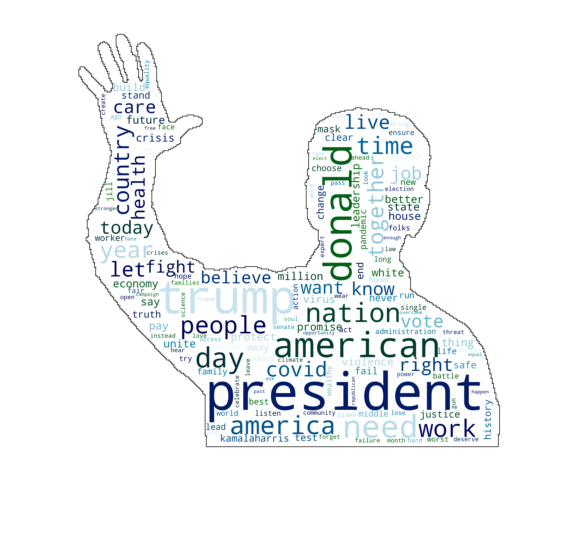

In [83]:
##Call the wordcloud function on biden tokens
wordcloud_biden= WordCloud(max_font_size=100, max_words=150,scale=10,relative_scaling=.6, background_color="white", contour_color="black",
                            contour_width= 3, mask= biden_image,colormap ="ocean", collocations=False).generate(', '.join(biden_tokens))

# Display the generated image:
plt.figure(figsize=(15,10))
plt.imshow(wordcloud_biden, interpolation='bilinear')
plt.axis("off")
plt.show()

# predicting Biden tweet's polarity using the Logistic regression model

In [84]:
#Convert the cleanTweet tokens to clean text for being used in vectorization
bidendf['cleanTweets'] = [','.join(map(str, lists)) for lists in bidendf['cleanTweets']]
bidendf.head(6)

Date  \
0  11/2/2020   
1  11/2/2020   
2  11/2/2020   
3  11/2/2020   
4  11/2/2020   
5  11/2/2020   

                                                                                                                                                                                              cleanTweets  \
0                                              donald,trump,most,corrupt,president,modern,history,donald,trump,most,racist,president,modern,history,donald,trump,worst,job,president,modern,history,years   
1                                                                                                                      truth,donald,trump,inherit,grow,economy,president,obama,like,inherit,life,squander   
2                                                                                                   america,vote,america,hear,america,hear,believe,message,loud,clear,time,donald,trump,leave,white,house   
3  biden,harris,administration,implement,nationwide,mask,mandate,ensure,access,regular,reliable,free,test,accelerate,development,distribution,safe,effective,treatments,vaccines,waste,time,virus,control   
4                                                                                                                                                             together,rebuild,economy,build,build,better   
5                                                            public,president,trump,compare,covid,flu,suggest,people,inject,bleach,treat,private,tell,bob,woodward,deadlier,flu,want,downplay,unthinkable   

   cleanTweets_count  
0                 22  
1                 12  
2                 16  
3                 24  
4                  6  
5                 20

In [85]:
#TF-IDF Vectorization on biden dataset
tfidfvec2 = TfidfVectorizer(max_features = 2000, ngram_range=(1,2)).fit(bidendf.cleanTweets)

# create matrix from the vectorizer
V2 = tfidfvec2.transform(bidendf.cleanTweets)
# print(V[0:5])
# create the transformed df
transformed_df2 = pd.DataFrame(V2.toarray(), columns=tfidfvec2.get_feature_names())
d2 = bidendf.join(transformed_df2)
d2 = d2.drop(["Date","cleanTweets", "cleanTweets_count"],axis = 1)
d2.head()


abandon  ability  able  abuse  accelerate  accelerate development  accept  \
0      0.0      0.0   0.0    0.0    0.000000                0.000000     0.0   
1      0.0      0.0   0.0    0.0    0.000000                0.000000     0.0   
2      0.0      0.0   0.0    0.0    0.000000                0.000000     0.0   
3      0.0      0.0   0.0    0.0    0.168651                0.168651     0.0   
4      0.0      0.0   0.0    0.0    0.000000                0.000000     0.0   

     access  access care  access free  access health  access regular  \
0  0.000000          0.0          0.0            0.0        0.000000   
1  0.000000          0.0          0.0            0.0        0.000000   
2  0.000000          0.0          0.0            0.0        0.000000   
3  0.131343          0.0          0.0            0.0        0.162353   
4  0.000000          0.0          0.0            0.0        0.000000   

   accessible  accomplish  accomplish together  accountable  achieve  act  \
0         0.0         0.0                  0.0          0.0      0.0  0.0   
1         0.0         0.0                  0.0          0.0      0.0  0.0   
2         0.0         0.0                  0.0          0.0      0.0  0.0   
3         0.0         0.0                  0.0          0.0      0.0  0.0   
4         0.0         0.0                  0.0          0.0      0.0  0.0   

   act sign  action  action contain  action ensure  action need  actively  \
0       0.0     0.0             0.0            0.0          0.0       0.0   
1       0.0     0.0             0.0            0.0          0.0       0.0   
2       0.0     0.0             0.0            0.0          0.0       0.0   
3       0.0     0.0             0.0            0.0          0.0       0.0   
4       0.0     0.0             0.0            0.0          0.0       0.0   

   actually  actually listen  address  administration  administration slow  \
0       0.0              0.0      0.0        0.000000                  0.0   
1       0.0              0.0      0.0        0.000000                  0.0   
2       0.0              0.0      0.0        0.000000                  0.0   
3       0.0              0.0      0.0        0.124671                  0.0   
4       0.0              0.0      0.0        0.000000                  0.0   

   administration work  affect  affirm  afford  afford years  affordable  \
0                  0.0     0.0     0.0     0.0           0.0         0.0   
1                  0.0     0.0     0.0     0.0           0.0         0.0   
2                  0.0     0.0     0.0     0.0           0.0         0.0   
3                  0.0     0.0     0.0     0.0           0.0         0.0   
4                  0.0     0.0     0.0     0.0           0.0         0.0   

   affordable accessible  african  african american  again  again donald  \
0                    0.0      0.0               0.0    0.0           0.0   
1                    0.0      0.0               0.0    0.0           0.0   
2                    0.0      0.0               0.0    0.0           0.0   
3                    0.0      0.0               0.0    0.0           0.0   
4                    0.0      0.0               0.0    0.0           0.0   

   against  against common  ago  ago today  ago white  ahead  ahead come  \
0      0.0             0.0  0.0        0.0        0.0    0.0         0.0   
1      0.0             0.0  0.0        0.0        0.0    0.0         0.0   
2      0.0             0.0  0.0        0.0        0.0    0.0         0.0   
3      0.0             0.0  0.0        0.0        0.0    0.0         0.0   
4      0.0             0.0  0.0        0.0        0.0    0.0         0.0   

   ahead together  allow  ally  alongside  alter  alter character  ambition  \
0             0.0    0.0   0.0        0.0    0.0              0.0       0.0   
1             0.0    0.0   0.0        0.0    0.0              0.0       0.0   
2             0.0    0.0   0.0        0.0    0.0              0.0       0.0   
3      

In [86]:
#Call the logistic regression model on biden data to predict the sentimnets of his tweets and store them on the predicted
#sentiment column
bidendf['predicted_sentiment'] = log_reg.predict(d2)
#Display the first 6 rows
bidendf.head(6)

Date  \
0  11/2/2020   
1  11/2/2020   
2  11/2/2020   
3  11/2/2020   
4  11/2/2020   
5  11/2/2020   

                                                                                                                                                                                              cleanTweets  \
0                                              donald,trump,most,corrupt,president,modern,history,donald,trump,most,racist,president,modern,history,donald,trump,worst,job,president,modern,history,years   
1                                                                                                                      truth,donald,trump,inherit,grow,economy,president,obama,like,inherit,life,squander   
2                                                                                                   america,vote,america,hear,america,hear,believe,message,loud,clear,time,donald,trump,leave,white,house   
3  biden,harris,administration,implement,nationwide,mask,mandate,ensure,access,regular,reliable,free,test,accelerate,development,distribution,safe,effective,treatments,vaccines,waste,time,virus,control   
4                                                                                                                                                             together,rebuild,economy,build,build,better   
5                                                            public,president,trump,compare,covid,flu,suggest,people,inject,bleach,treat,private,tell,bob,woodward,deadlier,flu,want,downplay,unthinkable   

   cleanTweets_count  predicted_sentiment  
0                 22                    1  
1                 12                    1  
2                 16                    1  
3                 24                    0  
4                  6                    0  
5                 20                    1

In [87]:
#Decoding the binary labels to Positive and Negative sentiment label for the visualization purpose 
decode_map = {0: "Negative", 1: "Positive"}
def sentiment_decode(label):
    return decode_map[int(label)]
bidendf.predicted_sentiment = bidendf.predicted_sentiment .apply(lambda x: sentiment_decode(x))
bidendf.head(3)

Date  \
0  11/2/2020   
1  11/2/2020   
2  11/2/2020   

                                                                                                                                                  cleanTweets  \
0  donald,trump,most,corrupt,president,modern,history,donald,trump,most,racist,president,modern,history,donald,trump,worst,job,president,modern,history,years   
1                                                                          truth,donald,trump,inherit,grow,economy,president,obama,like,inherit,life,squander   
2                                                       america,vote,america,hear,america,hear,believe,message,loud,clear,time,donald,trump,leave,white,house   

   cleanTweets_count predicted_sentiment  
0                 22            Positive  
1                 12            Positive  
2                 16            Positive

In [88]:
#Print the percentage of positive and negative tweets of Donald Trump
bPositive_sents= round(len(bidendf[bidendf['predicted_sentiment']== "Positive"])*100/len(bidendf['predicted_sentiment']),2)
bNegative_sents= 100-bPositive_sents

print("Biden Positive Sentiment percentage is:")
print(bPositive_sents , "%")    
print("Biden Negative Sentiment percentage is:")
print(bNegative_sents , "%")

Biden Positive Sentiment percentage is:
63.15 %
Biden Negative Sentiment percentage is:
36.85 %


# Visualizations

In [89]:
#Create column called month on biden dataset based on tweets date
import datetime
bidendf['month'] = pd.DatetimeIndex(bidendf['Date']).month

In [90]:
# Decode months to get months name for visualization
decode_map = {5: "May", 6: "June", 7: "July", 8: "August", 9: "September", 10: "October", 11: "November"}
def Month_decode(label):
    return decode_map[int(label)]
bidendf.month = bidendf.month.apply(lambda x: Month_decode(x))

In [91]:
# Get the count of positive and negative tweets of Biden in each month; Here we Group by month
biden_sentiment = bidendf.groupby(['month', 'predicted_sentiment']).predicted_sentiment.count().unstack()

In [92]:
#Calculate the number of tweets per month and percentage of positive and negative tweets on each month and create columns associated to them
biden_sentiment['Total_sentiments'] = biden_sentiment['Negative'] + biden_sentiment['Positive']
biden_sentiment['Biden_PositiveSent_Percentage'] = round(100*biden_sentiment['Positive']/biden_sentiment['Total_sentiments'],2)
biden_sentiment['Biden_NegativeSent_Percentage'] =round(100*biden_sentiment['Negative']/biden_sentiment['Total_sentiments'],2)

In [93]:
#Drop Columns that we do not need
biden_sentiment1 = biden_sentiment.drop(["Negative","Positive", "Total_sentiments"],axis = 1)
#Display part of the data
biden_sentiment1.head(5)

predicted_sentiment  Biden_PositiveSent_Percentage  \
month                                                
August                                       64.08   
July                                         52.70   
June                                         74.03   
May                                          50.91   
November                                     55.88   

predicted_sentiment  Biden_NegativeSent_Percentage  
month                                               
August                                       35.92  
July                                         47.30  
June                                         25.97  
May                                          49.09  
November                                     44.12

In [94]:
#We create a dataframe from above for visualization 
data = {'month':['May', 'June', 'July', 'August', 'September', 'October', 'November'], 
        'Biden_PositiveSent_Percentage':[50.91,74.03,52.70,64.08,64.56,67.31,55.88], 
        'Biden_NegativeSent_Percentage':[49.09,25.97,47.30,35.92,35.44,32.62,44.12]}
biden_monthly=pd.DataFrame(data, columns =['month', 'Biden_PositiveSent_Percentage','Biden_NegativeSent_Percentage'])
print(biden_monthly)

       month  Biden_PositiveSent_Percentage  Biden_NegativeSent_Percentage
0        May                          50.91                          49.09
1       June                          74.03                          25.97
2       July                          52.70                          47.30
3     August                          64.08                          35.92
4  September                          64.56                          35.44
5    October                          67.31                          32.62
6   November                          55.88                          44.12


In [95]:
#Plot biden tweets sentiment ratio per each month (From May to November 2nd)
import plotly.graph_objects as go

Months = ['May', 'June', 'July', 'August', 'September', 'October', 'November']
lis_pos_percent = [50.91,74.03,52.70,64.08,64.56,67.31,55.88]
lis_neg_percent = [49.09,25.97,47.30,35.92,35.44,32.62,44.12]

fig1 = go.Figure(data=[
    go.Bar(name='Positive', x=Months, y=lis_pos_percent , marker_color = 'teal'),
    go.Bar(name='Negative', x=Months, y=lis_neg_percent, marker_color = 'salmon') 
])
# Change the bar mode
fig1.update_layout(barmode='group', title = "Biden Tweets Sentiment Ratio Per each Month", xaxis_title= "Month", 
                  yaxis_title = "Sentiment Percentage", legend_title = "Sentiment")
fig1.show()

### Here we will do the same process for trump dataset

In [96]:
#Create column called month on trump dataset based on tweets date
trumpdf['month'] = pd.DatetimeIndex(trumpdf['Date']).month

In [97]:
# Decode months to get months name for visualization
decode_map = {5: "May", 6: "June", 7: "July", 8: "August", 9: "September", 10: "October", 11: "November"}
def Month_decode(label):
    return decode_map[int(label)]
trumpdf.month = trumpdf.month.apply(lambda x: Month_decode(x))

In [98]:
# Get the count of positive and negative tweets of trump in each month; Here we Group by month
trump_sentiment = trumpdf.groupby(['month', 'predicted_sentiment']).predicted_sentiment.count().unstack()

In [99]:
#Calculate the number of tweets per month and percentage of positive and negative tweets on each month and create columns associated to them
trump_sentiment['Total_sentiments'] = trump_sentiment['Negative'] + trump_sentiment['Positive']
trump_sentiment['Trump_PositiveSent_Percentage'] = round(100*trump_sentiment['Positive']/trump_sentiment['Total_sentiments'],2)
trump_sentiment['Trump_NegativeSent_Percentage'] =round(100*trump_sentiment['Negative']/trump_sentiment['Total_sentiments'],2)

In [100]:
#Drop Columns that we do not need
trump_sentiment1 = trump_sentiment.drop(["Negative","Positive", "Total_sentiments"],axis = 1)
#Display part of the data
trump_sentiment1.head(7)

predicted_sentiment  Trump_PositiveSent_Percentage  \
month                                                
August                                       55.61   
July                                         57.67   
June                                         49.06   
May                                          50.52   
November                                     53.85   
October                                      55.56   
September                                    52.11   

predicted_sentiment  Trump_NegativeSent_Percentage  
month                                               
August                                       44.39  
July                                         42.33  
June                                         50.94  
May                                          49.48  
November                                     46.15  
October                                      44.44  
September                                    47.89

In [101]:
#We create a dataframe from above for visualization 
data = {'month':['May', 'June', 'July', 'August', 'September', 'October', 'November'], 
        'Trump_PositiveSent_Percentage':[50.52,49.06,57.67,55.61,52.11,55.56,53.85], 
        'Trump_NegativeSent_Percentage':[49.48,50.94,42.33,44.39,47.89,44.44,46.15]}
trump_monthly=pd.DataFrame(data, columns =['month', 'Trump_PositiveSent_Percentage','Trump_NegativeSent_Percentage'])
print(trump_monthly)

       month  Trump_PositiveSent_Percentage  Trump_NegativeSent_Percentage
0        May                          50.52                          49.48
1       June                          49.06                          50.94
2       July                          57.67                          42.33
3     August                          55.61                          44.39
4  September                          52.11                          47.89
5    October                          55.56                          44.44
6   November                          53.85                          46.15


In [102]:
#Plot trump tweets sentiment ratio per each month (From May to November 2nd)

Months = ['May', 'June', 'July', 'August', 'September', 'October', 'November']
lis_pos_percent = [50.52,49.06,57.67,55.61,52.11,55.56,53.85]
lis_neg_percent = [49.48,50.94,42.33,44.39,47.89,44.44,46.15]

fig2 = go.Figure(data=[
    go.Bar(name='Positive', x=Months, y=lis_pos_percent, marker_color = 'teal'),
    go.Bar(name='Negative', x=Months, y=lis_neg_percent, marker_color = 'salmon')
])
# Change the bar mode
fig2.update_layout(barmode='group', title = "Trump Tweets Sentiment Ratio Per each Month", xaxis_title= "Month", 
                  yaxis_title = "Sentiment Percentage", legend_title = "Sentiment")
fig2.show()

In [103]:
#Overal Sentiment results for both candidates for comparison purpose 
Politicians = ['Donald Trump', 'Joe Biden']
lis_pos = [tPositive_sents, bPositive_sents]
lis_neg = [tNegative_sents, bNegative_sents]

fig3 = go.Figure(data=[
    go.Bar(name='Positive', x=Politicians, y=lis_pos, marker_color = 'teal' ),
    go.Bar(name='Negative', x=Politicians, y=lis_neg,  marker_color = 'salmon')
])
# Change the bar mode
fig3.update_layout(barmode='group', title = "Candidates Overal tweets Sentiment comparison", xaxis_title= "Presidential Candidates", 
                  yaxis_title = "Sentiment Percentage", legend_title = "Sentiment")
fig3.show()

In [104]:
#Merge trump and biden monthly sentiments in one dataframe for visulization 
trump_biden_merged = pd.merge(biden_monthly, trump_monthly, on = 'month')

In [105]:
#Keep only positive sentiments for both candidate for comparison of their positive tweets change over the defined time period
trump_biden_positiveSents = trump_biden_merged.drop("Biden_NegativeSent_Percentage",axis=1)
trump_biden_positiveSents= trump_biden_positiveSents.drop("Trump_NegativeSent_Percentage", axis=1)
print(trump_biden_positiveSents)

       month  Biden_PositiveSent_Percentage  Trump_PositiveSent_Percentage
0        May                          50.91                          50.52
1       June                          74.03                          49.06
2       July                          52.70                          57.67
3     August                          64.08                          55.61
4  September                          64.56                          52.11
5    October                          67.31                          55.56
6   November                          55.88                          53.85


C:\Users\ellie\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning:

FixedFormatter should only be used together with FixedLocator



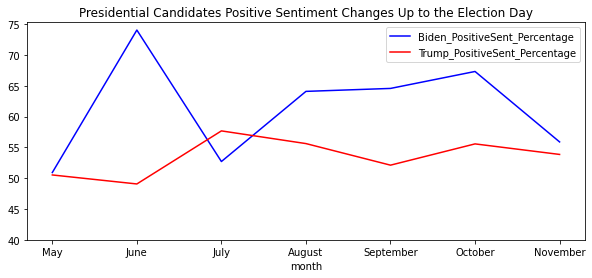

In [106]:
# Plot the candidate positive sentiments tweets change over time
ax = plt.gca()
trump_biden_positiveSents.plot(kind='line',x='month',y='Biden_PositiveSent_Percentage', color='blue', ax=ax,  figsize=(10,4))
trump_biden_positiveSents.plot(kind='line',x='month',y='Trump_PositiveSent_Percentage', color='red', ax=ax , figsize=(10,4))
ax.set_ylim(ymin=40)
plt.title('Presidential Candidates Positive Sentiment Changes Up to the Election Day')
plt.show()


## 

## References 
https://www.geeksforgeeks.org/string-punctuation-in-python/
    
https://medium.com/tusharsri/remove-add-stop-words-7e2994c19c67
    
https://towardsdatascience.com/sentiment-analysis-introduction-to-naive-bayes-algorithm-96831d77ac91
    
https://www.geeksforgeeks.org/reset-index-in-pandas-dataframe/
